## Ethiopia Nutrition Adequacy



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [49]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Demand Analysis for Ethopia, 2018-2019



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ethiopia example that I wish to work
through.



In [50]:
Ethiopia = '1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E'

In [51]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
Ethiopia = '1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E'
# Change 'Ethiopia_Data' to key of your own sheet in Sheets, above
r = read_sheets(Ethiopia,sheet='Food Expenditures (2018-19)')
r['i'] = r['i'].astype(str)
r = r.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Ethiopia,sheet='Food Prices (2018-19)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
p = p[r.index.levels[-1]].T

# Household characteristics
d = read_sheets(Ethiopia,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
#r = r.T.groupby(['i','t','m','j']).sum()
r = r.groupby(['i', 't', 'm', 'j']).sum(numeric_only=True)
r = r.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
v = np.log(r)

d = d[d['t'] == '2018-19']
d.set_index(['i','t','m'],inplace=True)

In [52]:
d.groupby('t').mean()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
t,,,,,,,,,,,,,,,
2018-19,0.216248,0.320384,0.286263,0.280798,0.53678,0.428508,0.173855,0.224963,0.316987,0.293205,0.26647,0.424225,0.402659,0.186706,1.302566


In [53]:
from cfe import Regression
import cfe
result1 = Regression(y=v,d=d)

In [54]:
result1.predicted_expenditures()

i                   t        m       j       
010101088800910017  2018-19  Tigray  Banana       13.722784
                                     Barley       25.973461
                                     Beef        163.760280
                                     Beetroot     10.094725
                                     Berbere      18.426590
                                                    ...    
7.10031E+16         2018-19  SNNP    Sugar         8.228985
                                     Tea           6.651267
                                     Teff         66.335750
                                     Tomato        7.975301
                                     Wheat        22.549419
Length: 191958, dtype: float64

<Axes: xlabel='vhat', ylabel='v'>

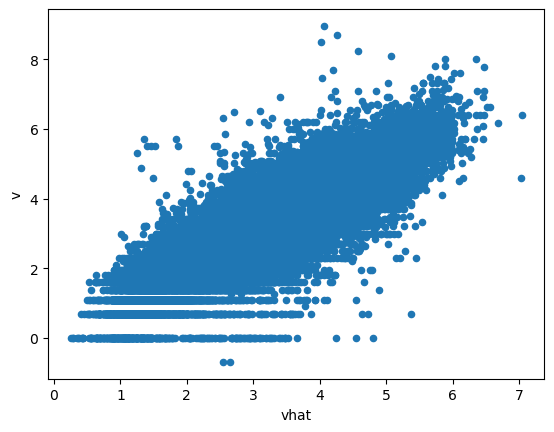

In [55]:
%matplotlib inline
jf = pd.DataFrame({'v':v,'vhat':result1.get_predicted_log_expenditures()})
jf.plot.scatter(x='vhat',y='v')

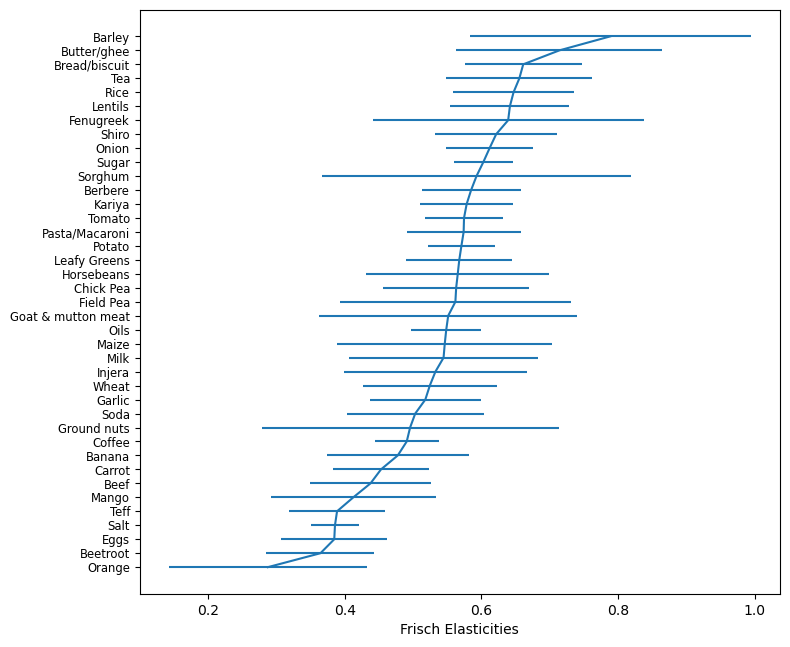

In [56]:
ar = result1.graph_beta()

In [57]:
result1.get_beta()

j
Banana                0.477468
Barley                0.788497
Beef                  0.437551
Beetroot              0.364255
Berbere               0.584863
Bread/biscuit         0.661144
Butter/ghee           0.714137
Carrot                0.452914
Chick Pea             0.562964
Coffee                0.490597
Eggs                  0.384479
Fenugreek             0.639107
Field Pea             0.561824
Garlic                0.517825
Goat & mutton meat    0.551291
Ground nuts           0.495533
Horsebeans            0.565291
Injera                0.532608
Kariya                0.578336
Leafy Greens          0.567523
Lentils               0.641650
Maize                 0.546274
Mango                 0.412395
Milk                  0.544517
Oils                  0.548439
Onion                 0.611916
Orange                0.287136
Pasta/Macaroni        0.573919
Potato                0.570635
Rice                  0.647001
Salt                  0.385525
Shiro                 0.621536
Soda  

In [58]:
result1.get_gamma()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,
Banana,-0.000223,-0.071820,-0.004488,0.008525,0.126822,0.139662,0.137181,0.020005,-0.085434,-0.055332,-0.031909,0.039605,0.221848,-0.048584,0.199641,3.184720
Barley,0.123631,0.015264,0.175775,0.077300,-0.024047,0.050901,0.119388,-0.137367,0.057757,-0.067983,0.086654,0.091864,-0.010543,0.118789,0.315278,3.279068
Beef,-0.077923,-0.166990,-0.061130,0.088782,0.054320,0.078641,0.094031,-0.053129,-0.072109,-0.101158,0.003401,0.014935,0.128632,0.035798,0.327651,5.249297
Beetroot,-0.037668,-0.010173,0.029583,0.049985,0.031633,0.008869,-0.033093,0.025121,0.039359,0.023534,0.103666,0.094776,0.058950,-0.064471,0.107883,2.567754
Berbere,-0.051770,-0.078390,-0.061653,0.010211,0.076010,0.112779,0.024342,-0.016952,-0.041730,-0.068965,-0.053570,0.010489,0.098185,-0.102997,0.202773,3.278178
Bread/biscuit,-0.109215,-0.126816,-0.064790,-0.049173,-0.035787,-0.062688,-0.061074,-0.110885,-0.055362,-0.000541,0.002074,-0.017882,0.083185,-0.067692,0.561302,3.353942
Butter/ghee,-0.034372,-0.027324,-0.008015,-0.071748,-0.001681,-0.016446,-0.062996,0.007327,-0.185239,-0.118303,0.057603,-0.151067,-0.030623,-0.083604,0.378682,4.061405
Carrot,-0.114253,-0.069433,-0.013742,0.116337,0.092286,0.078432,-0.040475,-0.053034,0.055146,-0.027860,0.006346,-0.040555,0.075077,-0.033651,0.198904,2.586219
Chick Pea,-0.066605,0.028546,0.058243,0.008947,-0.029816,-0.035917,0.036748,-0.074359,0.026539,-0.030653,0.067405,0.024487,-0.017291,-0.018822,0.379831,3.167594


<Axes: ylabel='Density'>

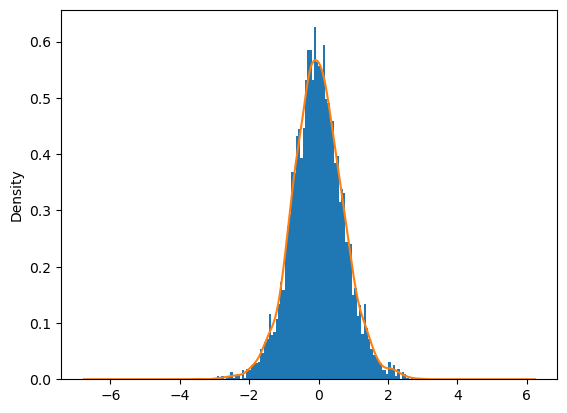

In [59]:
ar = result1.get_w().plot.hist(bins=100,density=True)
result1.get_w().plot.kde(ax=ar)

In [60]:
result1.to_pickle('ethiopia_estimate1516.rgsn')
result1 = cfe.regression.read_pickle('ethiopia_estimate1516.rgsn')

In [61]:
rhat = result1.predicted_expenditures()

# Total food expenditures per household
rbar = rhat.groupby(['i','t','m']).sum()

# Reference budget
rref = rbar.quantile(0.5)  # Household at 0.5 quantile is median

In [62]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result1.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

Text(0.5, 0, 'Quantities of Teff Demanded')

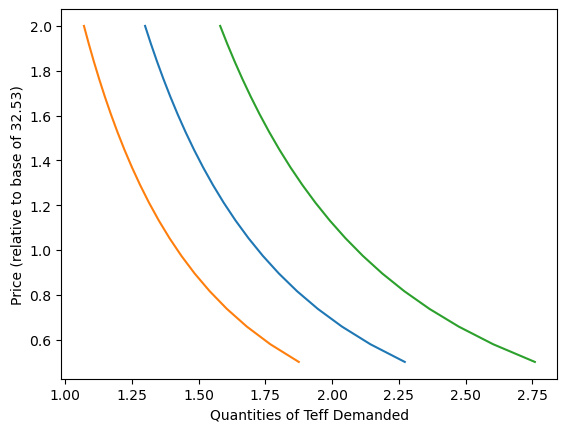

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Teff'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result1.demands(rref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result1.demands(rbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result1.demands(rbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

Text(0.5, 1.0, 'Engel Curves')

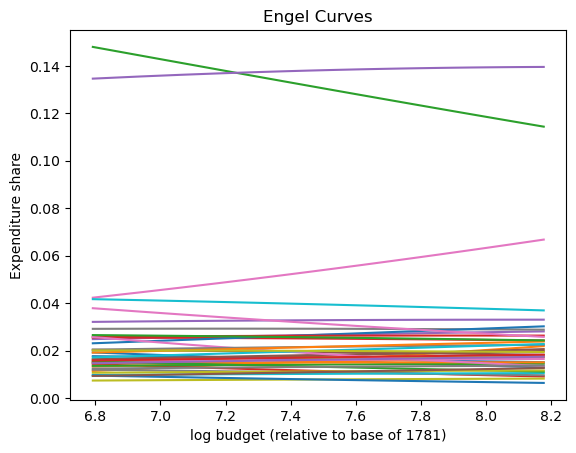

In [64]:
fig,ar = plt.subplots()

ar.plot(np.log(scale*rref),[result1.expenditures(s*rref,pbar)/(s*rref) for s in scale])
ar.set_xlabel(f'log budget (relative to base of {rref:.0f})')
ar.set_ylabel(f'Expenditure share')
ar.set_title('Engel Curves')

Text(0.5, 1.0, 'Indirect Utility Function')

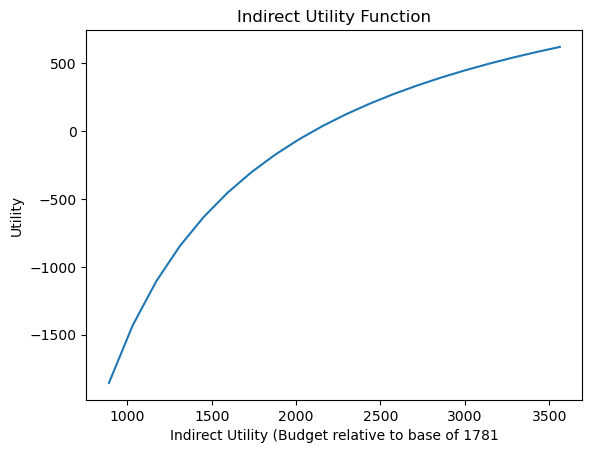

In [65]:
fig,ax = plt.subplots()

ax.plot(scale*rref,[result1.indirect_utility(s*rref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {rref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')

# Nutrient Ratios for Ethopia, 2018-2019

In [66]:
InputFiles = {'Expenditures':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Food Expenditures (2018-19)'),
              'Prices':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Food Prices (2018-19)'),
              'HH Characteristics':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Household Characteristics'),
              'FCT':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

In [67]:
def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

## important to keep the type of household id value as str.
x['i'] = x['i'].astype(str)

x = x.set_index(['i','t','m', 'j'])


# x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
q = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in q.columns:  # Supply "market" indicator if missing
    q['m'] = 1

q = q[q['u'] == 'Kg']
q = q.drop(columns = ['u'])
q = q.set_index(['t','m', 'j'])

q = q.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.rename(columns={'index':'j'})
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
fct = fct.replace(np.nan, 0)

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

In [68]:
result2 = cfe.Regression(y=np.log(x['Expenditure']),d=z)
result2.get_beta().sort_values(ascending=False) # Check sanity...

j
Barley                0.788497
Butter/ghee           0.714137
Bread/biscuit         0.661144
Tea                   0.655502
Rice                  0.647001
Lentils               0.641650
Fenugreek             0.639107
Shiro                 0.621536
Onion                 0.611916
Sugar                 0.602717
Sorghum               0.592757
Berbere               0.584863
Kariya                0.578336
Tomato                0.574467
Pasta/Macaroni        0.573919
Potato                0.570635
Leafy Greens          0.567523
Horsebeans            0.565291
Chick Pea             0.562964
Field Pea             0.561824
Goat & mutton meat    0.551291
Oils                  0.548439
Maize                 0.546274
Milk                  0.544517
Injera                0.532608
Wheat                 0.524379
Garlic                0.517825
Soda                  0.503051
Ground nuts           0.495533
Coffee                0.490597
Banana                0.477468
Carrot                0.452914
Beef  

In [69]:
result2.to_pickle('./foo.pickle')

In [70]:
result2 = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...
xhat = result2.predicted_expenditures()
# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/q['Price'].unstack('j')).dropna(how='all')
# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [71]:
use = fct.index.intersection(qhat.columns)
nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean() 

n
Energy          85619.701784
Protein          2788.874698
Vitamin A       30657.669391
Vitamin D         164.809077
Vitamin E         233.993878
Vitamin C        2288.261339
Vitamin B-6        80.089942
Vitamin B-12      199.588358
Calcium         28147.902072
Magnesium       20477.762998
Iron              935.701002
Zinc              468.253444
Fiber             544.176977
Folate           1762.482492
Carbohydrate     4190.279451
Niacin            209.776618
Phosphorus      23701.933118
Potassium       29949.356722
Riboflavin         16.551513
Thiamin            24.284273
Vitamin K         135.914670
dtype: float64

In [72]:
z.columns = [
    col.replace('Females', 'F')
       .replace('Males', 'M')
       .replace('51-99', '51+')
    for col in z.columns
]

In [73]:
z

F 00-03  F 04-08  F 09-13  F 14-18  F 19-30  \
i              t       m                                                        
1010101601002  2011-12 Tigray           0        0        1        0        0   
               2013-14 Tigray           1        1        1        0        0   
               2015-16 Tigray           0        0        0        0        0   
1010101601017  2011-12 Tigray           0        1        1        0        0   
               2013-14 Tigray           1        1        1        0        1   
...                                   ...      ...      ...      ...      ...   
15010203102109 2013-14 Dire Dawa        0        0        0        0        0   
               2015-16 Dire Dawa        0        1        0        0        0   
15010203102121 2011-12 Dire Dawa        0        0        1        0        1   
               2013-14 Dire Dawa        0        0        1        0        1   
               2015-16 Dire Dawa        0        0        1        0        0   

                                  F 31-50  F 51+  M 00-03  M 04-08  M 09-13  \
i              t       m                                                      
1010101601002  2011-12 Tigray           1      1        0        1        1   
               2013-14 Tigray           1      1        0        1        0   
               2015-16 Tigray           0      1        0        0        0   
1010101601017  2011-12 Tigray           1      0        0        0        2   
               2013-14 Tigray           0      0        0        1        1   
...                                   ...    ...      ...      ...      ...   
15010203102109 2013-14 Dire Dawa        0      1        0        0        0   
               2015-16 Dire Dawa        0      1        0        0        0   
15010203102121 2011-12 Dire Dawa        1      0        0        1        1   
               2013-14 Dire Dawa        1      0        0        1        1   
               2015-16 Dire Dawa        1      0        0        0        1   

                                  M 14-18  M 19-30  M 31-50  M 51+  log HSize  
i              t       m                                                       
1010101601002  2011-12 Tigray           1        0        1      0   1.945910  
               2013-14 Tigray           1        0        1      0   2.079442  
               2015-16 Tigray           0        0        0      0   0.000000  
1010101601017  2011-12 Tigray           0        0        1      0   1.791759  
               2013-14 Tigray           1        0        1      0   2.079442  
...                                   ...      ...      ...    ...        ...  
15010203102109 2013-14 Dire Dawa        0        1        0      0   0.693147  
               2015-16 Dire Dawa        0        0        0      0   0.693147  
15010203102121 2011-12 Dire Dawa        0        0        0      0   1.609438  
               2013-14 Dire Dawa        0        0        0      0   1.609438  
               2015-16 Dire Dawa        1        0        0      0   1.386294  

[20896 rows x 15 columns]

In [74]:
z = z[rdi.columns.tolist()]
hh_rdi = z@rdi.T
hh_rwi = hh_rdi*7

In [75]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
#nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
nutrient_ratio = (nutrients[use_nutrients] / hh_rwi[use_nutrients].where(hh_rwi[use_nutrients] != 0)).dropna()


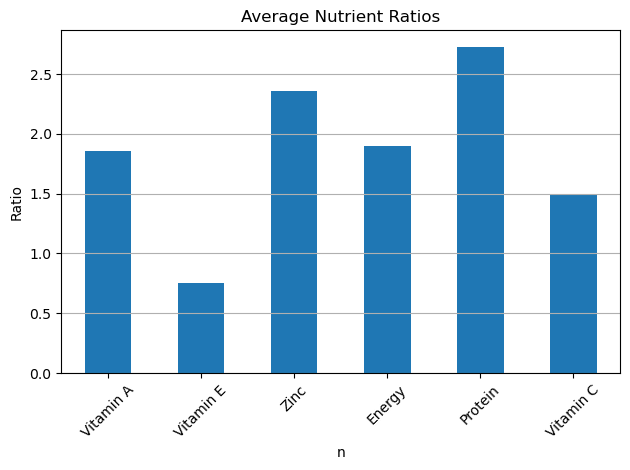

In [76]:
selected_nutrients = ['Vitamin A', 'Vitamin E', 'Zinc', 'Energy', 'Protein', 'Vitamin C']
nutrient_means = nutrient_ratio[selected_nutrients].mean()
nutrient_means.plot(kind='bar')
plt.title('Average Nutrient Ratios')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<Axes: >

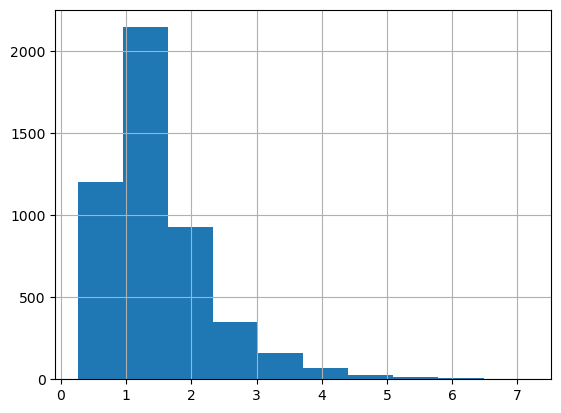

In [77]:
protein_data = nutrient_ratio['Vitamin C']
protein_data.hist()

# Nutrient Demands for Ethopia, 2018-2019

### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [78]:
import pandas as pd
import cfe.regression as rgsn

Using the data on household characteristics and (log) expenditures, we can estimate the demand system (`d`,=y=).  This gives us predictions of expenditures on different kinds of foods.  Then if we divide these expenditures by prices, we get predicted quantities of food.

However, here we&rsquo;re interested in nutritional outcomes, so we need a food conversion table:



In [79]:
fct.head(), rdi.head()

(n             Energy  Protein  Vitamin A  Vitamin D  Vitamin E  Vitamin C  \
 j                                                                           
 Avocado  1601.338432     20.0         70          0       20.7        100   
 Banana    890.000000     11.0         30          0        1.0         87   
 Barley   3490.000000    123.0          0          0       10.0          0   
 Beef     3230.000000    249.0          0          0        0.0          0   
 Beer      410.000000      3.0          0          0        0.0          0   
 
 n        Vitamin B-6  Vitamin B-12  Calcium  Magnesium  ...  Zinc  Fiber  \
 j                                                       ...                
 Avocado         2.57             0    120.0      290.0  ...   6.4   67.0   
 Banana          4.00             0     50.0      270.0  ...   2.0    0.0   
 Barley          2.00             0    260.0      920.0  ...  20.0    0.0   
 Beef            3.00            19     40.0      230.0  ...  41.0 

We also want to establish when nutrition is *adequate* for households with different compositions.  For this, we want data on recommended dietary intakes:



#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Ethiopia:



In [80]:
# Assumes you've already set this up e.g., in Project 3
r = rgsn.read_pickle('./foo.pickle')

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [81]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.loc[r.beta.index].mean(axis=1).fillna(1) # Only use prices for goods we can estimate

#### Budgets



Get food budget for all households, then find median budget:



In [82]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [83]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Banana,Barley,Beef,Beetroot,Berbere,Bread/biscuit,Butter/ghee,Carrot,Chick Pea,Coffee,...,Rice,Salt,Shiro,Soda,Sorghum,Sugar,Tea,Teff,Tomato,Wheat
i,t,m,,,,,,,,,,,,,,,,,,,,,
010101088800910017,2018-19,Tigray,0.413448,0.873332,0.629931,0.394955,0.186324,0.362870,0.101935,0.332159,0.677600,0.161405,...,0.656097,0.114999,0.410137,0.403431,3.539112,0.321945,0.150474,4.458301,0.502392,2.924948
010101088800910026,2018-19,Tigray,0.513472,0.799811,0.617154,0.370081,0.162010,0.309491,0.101811,0.256859,0.563979,0.153774,...,0.557511,0.100283,0.403814,0.419849,3.966817,0.290751,0.149741,4.397499,0.451142,2.399674
010101088800910029,2018-19,Tigray,0.545041,0.715252,0.682824,0.387508,0.227877,0.370559,0.175109,0.285523,0.576399,0.188726,...,0.531924,0.098739,0.438953,0.497123,3.787831,0.310494,0.195002,3.436222,0.570477,2.085938
010101088800910046,2018-19,Tigray,0.420057,0.566860,0.496171,0.376181,0.182603,0.358792,0.123134,0.253919,0.600295,0.167946,...,0.681969,0.109439,0.377164,0.386025,2.931917,0.381308,0.173901,4.099479,0.487625,3.417713
010101088800910054,2018-19,Tigray,0.539680,0.799779,0.648509,0.394967,0.223485,0.399198,0.193097,0.283582,0.676502,0.193055,...,0.713396,0.112441,0.443617,0.477688,4.135037,0.388627,0.218546,4.067916,0.617499,2.716165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.0511E+16,2018-19,Somali,2.205409,3.409047,1.082480,0.837192,0.227766,1.718588,0.232490,1.252165,0.916014,0.345938,...,4.307922,0.315860,1.046515,1.739275,3.821920,2.422879,0.525154,4.201316,1.876677,3.838458
6.0104E+16,2018-19,Benishangul-Gumuz,0.606798,0.768066,0.820877,0.620629,0.348293,0.786185,0.332224,0.720905,0.858413,0.333594,...,0.976222,0.219212,0.652867,0.805118,4.570689,0.759980,0.281383,5.611119,1.139309,2.070048
7.0211E+16,2018-19,SNNP,0.444011,0.828702,0.690302,0.434735,0.267096,0.634788,0.393360,0.537671,0.472582,0.235554,...,0.501562,0.169056,0.464483,0.881795,1.019647,0.373515,0.264338,2.737195,0.813911,1.625396


Finally, define a function to change a single price in the vector $p$:



In [84]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



In [85]:
%matplotlib inline

Text(0.5, 0, 'Quantities of Teff Demanded')

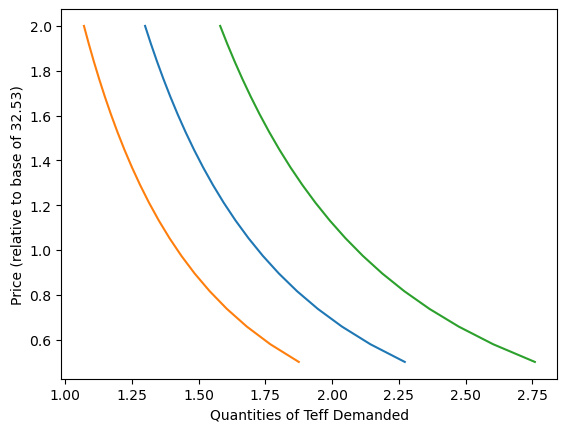

In [86]:
import matplotlib.pyplot as plt

use = 'Teff'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Teff for household at median budget
plt.plot([r.demands(xref,my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Teff for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Teff for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



Text(0.5, 1.0, 'Engel Curves')

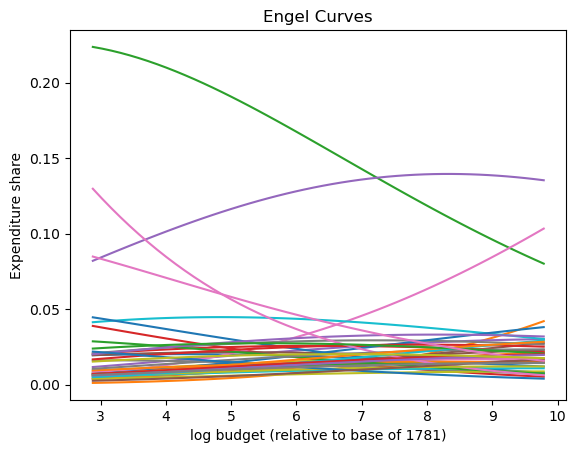

In [87]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [88]:
fct

n,Energy,Protein,Vitamin A,Vitamin D,Vitamin E,Vitamin C,Vitamin B-6,Vitamin B-12,Calcium,Magnesium,...,Zinc,Fiber,Folate,Carbohydrate,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin K
j,,,,,,,,,,,,,,,,,,,,,
Avocado,1601.338432,20.00000,70,0,20.7,100,2.570,0,120.00,290.0,...,6.400,67.00,810.0,85.30000,17.38,520.0,4850.0,1.300,0.6700,210.0
Banana,890.000000,11.00000,30,0,1.0,87,4.000,0,50.00,270.0,...,2.000,0.00,0.0,0.00000,0.00,0.0,0.0,0.000,0.0000,0.0
Barley,3490.000000,123.00000,0,0,10.0,0,2.000,0,260.00,920.0,...,20.000,0.00,0.0,0.00000,0.00,0.0,0.0,0.000,0.0000,0.0
Beef,3230.000000,249.00000,0,0,0.0,0,3.000,19,40.00,230.0,...,41.000,0.00,0.0,0.00000,0.00,0.0,0.0,0.000,0.0000,0.0
Beer,410.000000,3.00000,0,0,0.0,0,1.000,0,50.00,60.0,...,0.000,0.00,0.0,0.00000,0.00,0.0,0.0,0.000,0.0000,0.0
Beetroot,430.210325,16.10000,20,0,0.4,49,0.670,0,160.00,230.0,...,3.500,28.00,1090.0,95.60000,3.34,400.0,3250.0,0.400,0.3100,2.0
Berbere,74.869981,8.95625,0,0,0.0,1417,3.027,0,63.61,109.8,...,2.023,11.58,473.2,66.53175,10.24,265.9,2127.0,1.422,0.5494,0.0
Boye/Yam,970.000000,21.00000,0,0,50.0,120,2.000,0,80.00,260.0,...,5.000,0.00,0.0,0.00000,0.00,0.0,0.0,0.000,0.0000,0.0
Bread/biscuit,2740.000000,80.00000,0,0,0.0,0,0.000,0,100.00,270.0,...,9.000,0.00,0.0,0.00000,0.00,0.0,0.0,0.000,0.0000,0.0


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [89]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Banana', 'Barley', 'Beef', 'Beetroot', 'Berbere', 'Bread/biscuit',
       'Butter/ghee', 'Coffee', 'Eggs', 'Fenugreek', 'Garlic',
       'Goat & mutton meat', 'Ground nuts', 'Injera', 'Leafy Greens', 'Maize',
       'Mango', 'Milk', 'Oils', 'Onion', 'Orange', 'Pasta/Macaroni', 'Potato',
       'Rice', 'Salt', 'Soda', 'Sorghum', 'Sugar', 'Tea', 'Teff'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [90]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Ethiopia quantities are for previous 7 days

i,010101088800910017,010101088800910026,010101088800910029,010101088800910046,010101088800910054,010101088800910062,010101088800910070,010101088800910082,010101088800910093,010102088801010034,...,3.0714E+16,4.1602E+16,4.2828E+16,4.303E+16,5.01031E+16,5.0511E+16,6.0104E+16,7.0211E+16,7.06101E+16,7.10031E+16
t,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,...,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19
m,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,...,Amhara,Oromia,Oromia,Oromia,Somali,Somali,Benishangul-Gumuz,SNNP,SNNP,SNNP
n,,,,,,,,,,,,,,,,,,,,,
Energy,53380.050977,53235.605392,50429.366970,48685.005319,56341.348321,57372.827743,65603.438217,62248.337280,55325.723046,86878.703613,...,97562.203018,82541.667922,79028.751053,61981.250286,151736.401845,126496.715165,77983.912865,45576.231485,27901.506279,25516.807031
Protein,1736.118281,1722.262115,1610.749420,1570.032496,1768.526338,1949.468521,2210.605769,2019.100747,1906.817566,2787.579815,...,3011.872218,2669.108125,2633.488564,2052.574553,4558.406602,3974.407603,2432.796133,1563.125313,1019.467722,895.658028
Vitamin A,15909.412372,16396.838544,16058.049863,14618.484919,16512.142427,17006.033646,21617.603242,18803.141734,16879.185629,26744.917524,...,27993.394248,21824.279763,22518.621806,18004.982934,70760.489323,66080.713643,25202.554574,25230.587212,13654.831369,12749.045316
Vitamin D,91.351447,90.875650,79.005142,82.119426,81.625516,92.803408,108.313681,92.213723,86.346191,138.177989,...,163.531270,106.812630,118.982946,90.318438,483.779721,414.093006,116.979149,117.597956,88.760439,66.720859
Vitamin E,106.156560,103.536199,111.530046,100.126589,116.467392,117.089583,145.220497,128.756248,117.183547,187.690439,...,244.275972,225.883200,202.042821,178.185166,405.523460,393.619226,192.256175,153.941307,73.723176,78.535618
Vitamin C,1686.106852,1634.627528,1426.365504,1510.154244,1488.866987,1520.325394,2287.733891,1715.183029,1680.477485,2444.654085,...,2545.675674,1704.821791,1778.898641,1423.603975,3309.315861,3269.840236,1660.352397,1926.556384,930.478525,1053.100395
Vitamin B-6,52.145114,51.959802,48.582217,47.453663,53.177158,57.862084,67.712244,61.030525,57.686774,82.212787,...,86.851560,74.302922,73.516794,57.887892,118.342360,109.497405,74.849432,46.985839,27.972875,26.995743


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [91]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

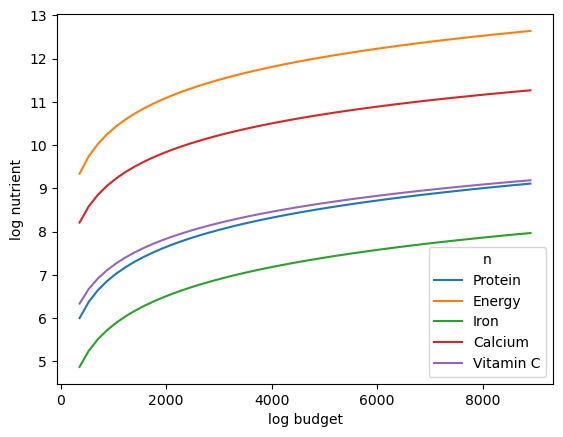

In [92]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



Text(0, 0.5, 'log nutrient')

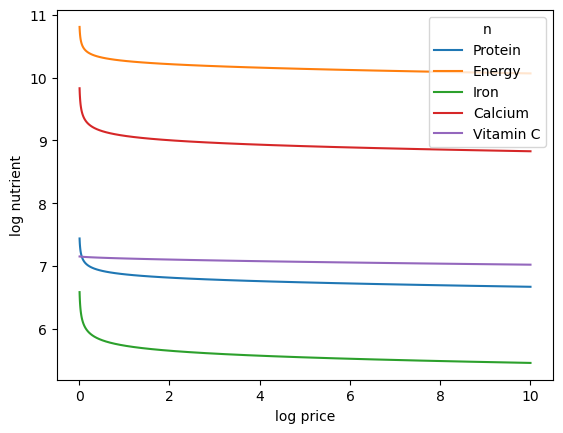

In [93]:
USE_GOOD = 'Teff'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [94]:
rdi_updated_col = rdi.copy()
rdi_updated_col.columns = [
    col.replace('F', 'Females')
       .replace('M', 'Males')
       .replace('51+', '51-99')
    for col in rdi_updated_col.columns
]

In [95]:
# In first round, averaged over households and villages
dbar = r.d[rdi_updated_col.columns].mean()

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [96]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi_updated_col@dbar

hh_rdi

n
Energy           7629.418935
Protein           171.352093
Fiber             106.811865
Folate           1427.377082
Calcium          4482.446160
Carbohydrate      554.995937
Iron               47.710687
Magnesium        1227.683868
Niacin             54.196668
Phosphorus       3346.921983
Potassium       18678.545307
Riboflavin          4.257883
Thiamin             4.131288
Vitamin A        2836.428281
Vitamin B-12        8.564262
Vitamin B-6         4.700223
Vitamin C         261.073751
Vitamin E          53.273872
Vitamin K         343.995327
Zinc               34.263714
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [97]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi_updated_col.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



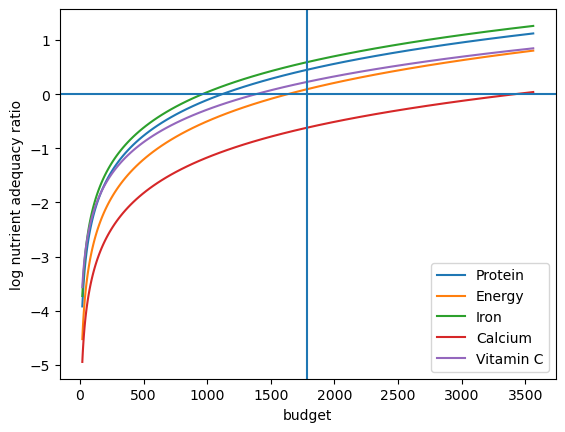

In [98]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



Text(0.5, 0, 'log nutrient adequacy ratio')

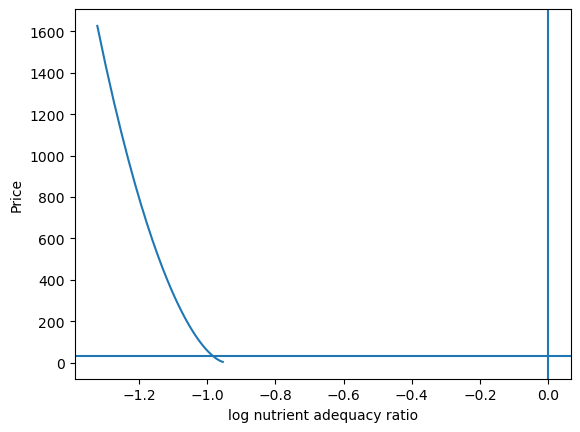

In [99]:
scale = np.geomspace(0.1, 50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(USE_GOOD,pbar[USE_GOOD]*s),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin C'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

Log graph is less than 0 which shows that when price is high, nutritional adequeacy ratio is very small.

# Costs
From the Demand section, we see the continuing use of the variables r, rdi, pbar, my_prices, xhat, xbar, xref

## Marshallian vs. Hicksian Demand Curves

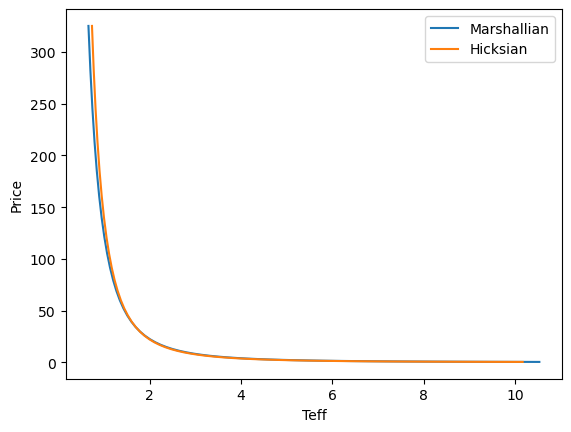

In [121]:
%matplotlib inline

my_j = 'Teff'  # Ethiopian food of reference

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = r.indirect_utility(xref,pbar)

plt.plot([r.demands(xref,my_prices(my_j,p0))[my_j] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(my_j,p0),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

## Welfare Measures

In [3]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

## Price Changes, Revenue, and Compensating Variation



Examine effects of price changes on revenue (if price change due to a tax or subsidy) and compensating variation.


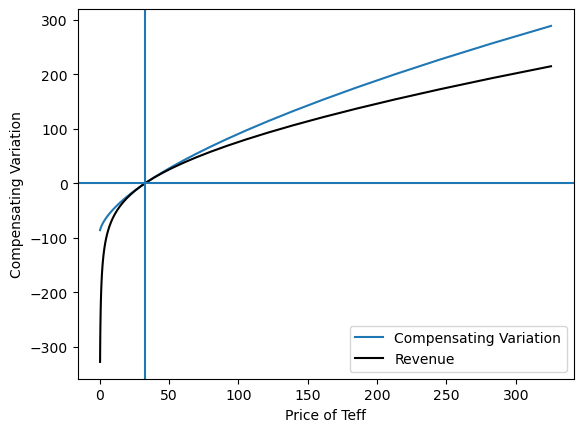

In [124]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(my_j,p0),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])